# 第3回のコード

資料はMATLABコードだが、ここではJuliaでの実装をする。

なおこのコードの実行の前に以下のパッケージをインストールする必要がある。

```
using Pkg
Pkg.add("IJulia")
Pkg.add("Plots")
Pkg.add("ApproxFun")
Pkg.add("SpecialFunctions")
Pkg.add("LaTeXStrings")
Pkg.add("FFTW")

```

## Aliasing errors

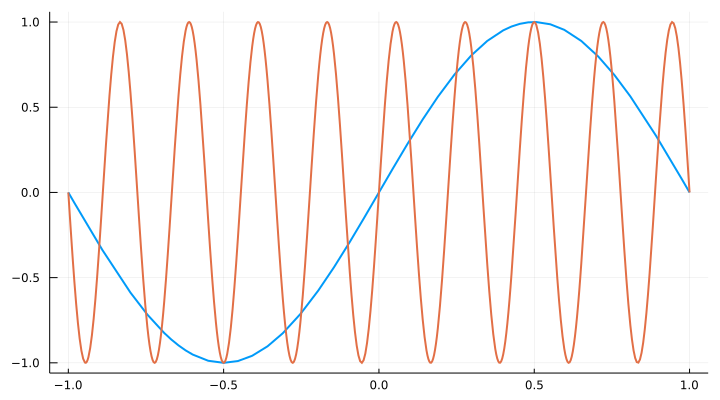

In [1]:
using Plots

f₁ = x->sinpi(x)
f₂ = x->sinpi(9x)

plot(f₁,-1,1,
    line       = 2,
    size       = (720,400),
    legend     = false,
)

plot!(f₂,-1,1,line=2)

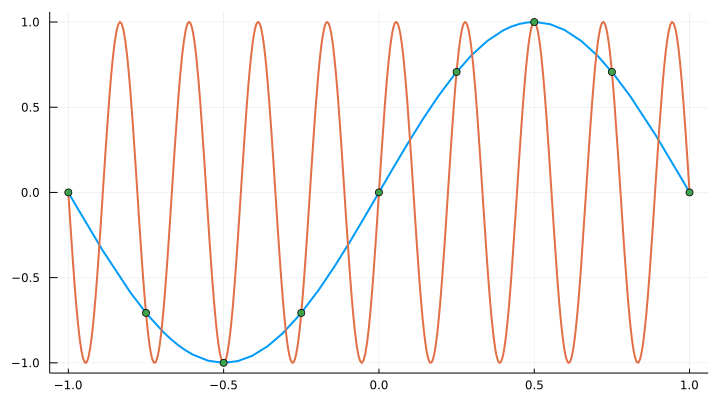

In [2]:
x = -1:0.25:1
scatter!(x,f₁.(x))

## Compute the convolution by FFT algorithm

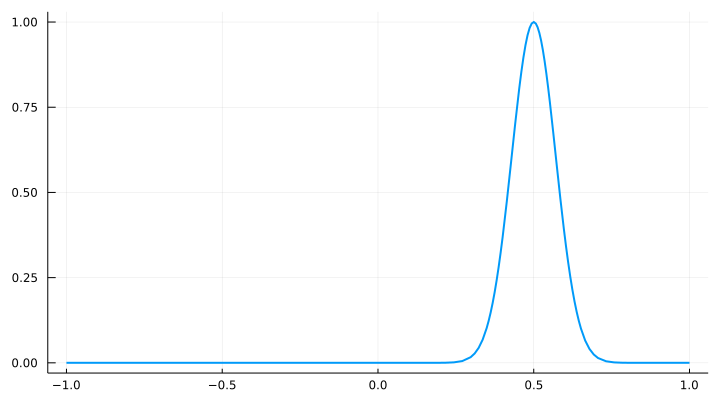

In [3]:
# using SpecialFunctions
# f = t -> exp(-erf(t^2)+(t-1)^3)
using Plots
f = x -> exp(-(100*(x-0.5)^2))
plot(f,-1,1,
    line       = 2,
    size       = (720,400),
    legend     = false,
)

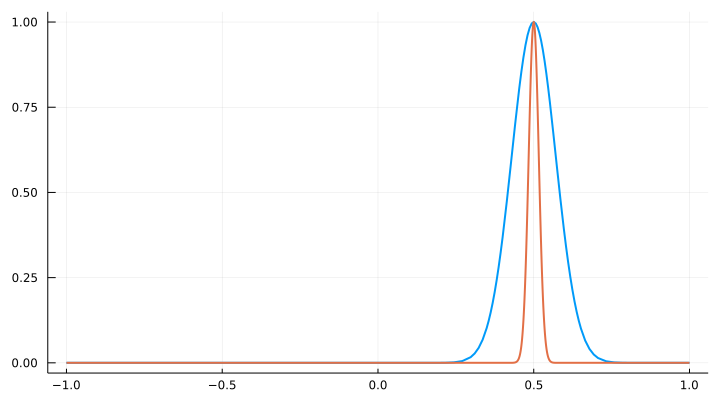

In [4]:
using ApproxFun, FFTW
fc = Fun(f)
M = ncoefficients(fc)
c = coefficients(fc) # Chebyshev coefficient
a = [reverse(0.5*c[2:end]); c[1]; 0.5*c[2:end]]# Fourier coefficient

p = 19
N = (p-1)*M
ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
tb = ifft(ifftshift(ta)) # 2. IFFT of ta
tbᵖ = tb.^p # 3. tb*^tb
cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1)) # 4. FFT of tb2
cᵖ_c = [cᵖ[N+M]; 2*cᵖ[N+M+1:N+M+p*(M-1)]]# Take Chebyshev coefficient

ff = Fun(Chebyshev(),cᵖ_c)
plot!(ff,line=2)

In [5]:
using LinearAlgebra
fᵖ = fc^p
norm(cᵖ_c[1:ncoefficients(fᵖ)]-coefficients(fᵖ),1)

4.046589237727261e-15

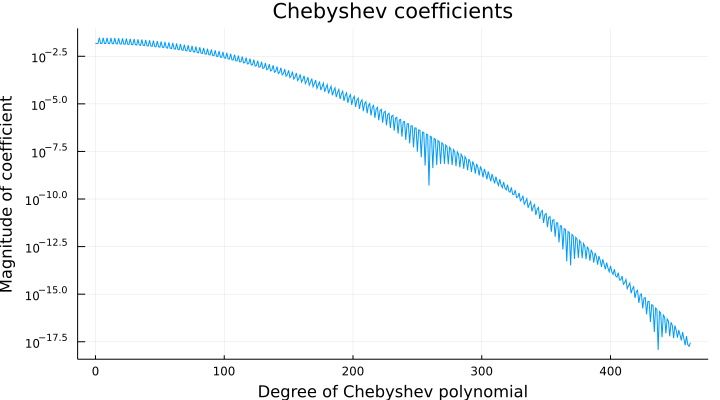

In [6]:
function plotcoeffs(f)
    plot(0:ncoefficients(f)-1, abs.(coefficients(f)),
        yscale=:log10,
        title="Chebyshev coefficients",
        xlabel="Degree of Chebyshev polynomial",
        ylabel="Magnitude of coefficient",
        size       = (720,400),
        legend     = false,
    )
end
plotcoeffs(fᵖ)

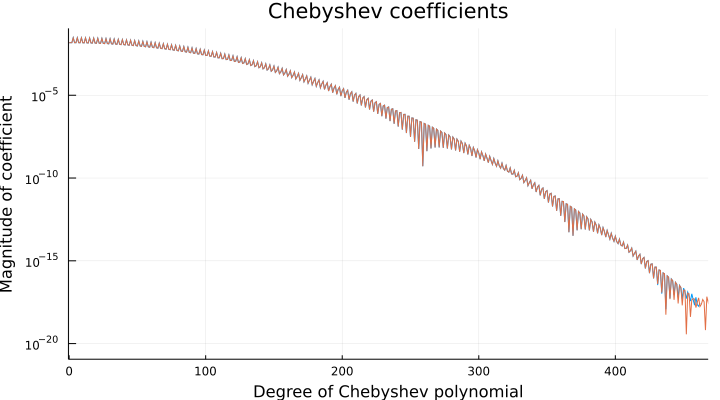

In [7]:
zero_ind = findall(x->x==0, cᵖ_c)
cᵖ_c[zero_ind] .= cᵖ_c[zero_ind.+1]
plot!(0:length(cᵖ_c)-1, abs.(cᵖ_c),
    yscale=:log10,
    xlims=(-0.5,ncoefficients(fᵖ)+5),
)

## Application: residual of an approximate solution by ApproxFun

$$
\frac{du}{dt} = u - u^p + u^r,\quad u(0)=0.5
$$

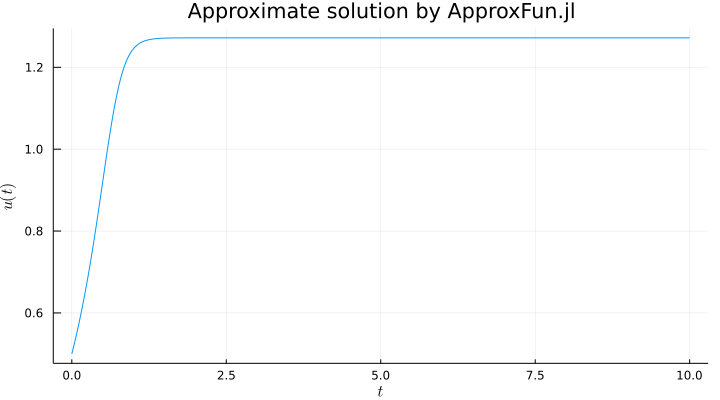

In [8]:
using ApproxFun
tmax = 10
p = 5
r = 3
x  = Fun(identity, 0..tmax)
u₀ = 0.5x # initial guess
N = u -> [u(0)-0.5, u' - u + u^p - u^r]
u = newton(N, u₀) # perform Newton iteration in function space
plot(u,
    title="Approximate solution by ApproxFun.jl",
    xlabel="\$t\$",
    ylabel="\$u(t)\$",
    size       = (720,400),
    legend     = false,
)

In [9]:
function convp(c,p)
    M = length(c)
    a = [reverse(0.5*c[2:end]); c[1]; 0.5*c[2:end]]# Fourier coefficient
    N = (p-1)*M
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1)) # 4. FFT of tb2
    return [cᵖ[N+M]; 2*cᵖ[N+M+1:N+M+p*(M-1)]]# return Chebyshev coefficient
end

function ChebDerCoeffs(c)
# NOTE: remind dividing by the rescaling factor (tmax/2)!
    size_of_c = size(c)
    if length(size_of_c) > 1
        n, m = size_of_c
    else
        n = size_of_c[1]; m=1
    end
    cout = zeros(n-1, m)
    w = repeat(2.0*(1:n-1), 1, m)
    v = w.*c[2:end,:]
    cout[n-1:-2:1,:] = cumsum(v[n-1:-2:1,:],dims=1)
    cout[n-2:-2:1,:] = cumsum(v[n-2:-2:1,:],dims=1)
    cout[1,:] = .5*cout[1,:]
    return cout
end

ChebDerCoeffs (generic function with 1 method)

In [10]:
uc = coefficients(u)
M = ncoefficients(u)
N = (p-1)*M

ucᵖ = convp(uc,p)
ucʳ = convp(uc,r)

if p >= r
    L = length(ucᵖ)-length(ucʳ)
    ucʳ = [ucʳ; zeros(L)];
else
    L = length(ucʳ)-length(ucᵖ)
    ucᵖ = [ucᵖ; zeros(L)]
end

#### 
# Differentiate the Chebyshev series by Chebfun
du = differentiate(u)
duc = coefficients(du)
duc = [duc; zeros((p-1)*(M-1)+1,1)]

# Differentiate the Chebyshev series by coefficients
rescaleFactork = tmax/2.0
duc2 = ChebDerCoeffs(uc)/rescaleFactork
duc2 = [duc2; zeros((p-1)*(M-1)+1)]
norm(duc-duc2,1)
# reshape([duc;duc2],length(duc),2)

1.0842534843702627e-16

In [11]:
uc = [uc;zeros((p-1)*(M-1))]
res = duc2 - uc + ucᵖ - ucʳ
norm(res,1)

2.853507547074021e-13